This model buils a simple Hierarchial mixed effect model to look at dose response from 5 clinical trials.

In this example we are model the mean response from 5 different clinical trials. The modelling examines the inter trial variation as well as residual variation in the data.

The response data is percentage change in LDL following dosing with a statin.

There trials vary in their size and the different dose levels given.

This example follows the video on you tube:

https://youtu.be/U9Nf-ZYHRQA?list=PLvLDbH2lpyXNGV8mpBdF7EFK9LQJzGL-Y

Beginning around 40mins

### Load in required libraries 

In [149]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [189]:
from pymc3 import Model, Normal, Lognormal, Uniform, trace_to_dataframe, df_summary

### Load in data and view

In [3]:
data = pd.read_csv('/5studies.csv')

In [4]:
data.head()

,Study,Dose,n,Mean_response
0,1,0,40,2.02
1,1,10,40,8.17
2,1,20,40,9.87
3,1,40,40,10.51
4,2,0,40,2.19


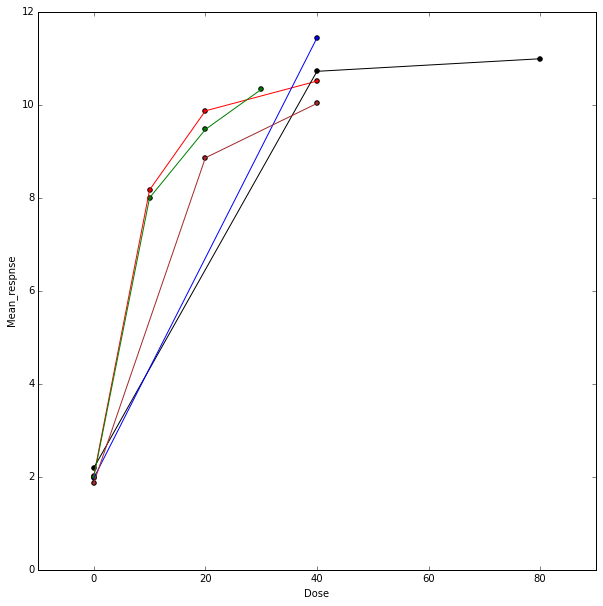

In [5]:
plt.figure(figsize =(10,10))
for study in data.Study.unique():
    cols = ['red', 'black', 'blue', 'brown', 'green'] 
    x = data.Dose[data.Study ==study]
    y = data.Mean_response[data.Study ==study]
    col = max(data.Study)
    plt.scatter(x, y, c=cols[study-1])
    plt.plot(x,y, c=cols[study-1])
plt.xlabel('Dose')
plt.ylabel('Mean_respnse')

### Manipulate data

Note the data passed into the model must be a np array. Although pandas series work ok in this example in more complex examples I have found that pandas series sometime throw indexing errors

In [166]:
mean_response = np.array(data.Mean_response)
dose = np.array(data.Dose)

# Since we are interested in modelling the inter study variation  
# we must create some variables to pass into the model parameters  
# How many studies...
n_studies = len(data.Study.unique())
# An array that is used to index the studies, reduced by -1 as the index starts at 0 not 1
study = np.array(data.Study.values-1)

# array to adjust sigma for sample size
n= np.array(data.n)

### Now build the model

The model is a simple emax model.
The independent variable is dose. The dependent is Mean_response with log normal residual variation.

Log of effect is normal

variance is sample size adjusted.

We place intertrial variation on emax and the baseline e0

In [140]:
pkpd_model = Model()

with pkpd_model:

    # Hyperparameter Priors
    # for the uniform values, as they are passed in to a Lognormal distribution
    # as the spread variable, they reflect a logged value, so upper =4 is equivalent to
    # tau = 10000
    mu_e0 = Normal('mu_e0',  mu=0, sd=100)
    omega_e0 = Uniform('omega_e0', lower=0, upper =4)
        
    mu_emax = Normal('mu_emax',  mu=0, sd=100)
    omega_emax = Uniform('omega_emax', lower=0, upper=4)
    
    # Note how the n_studies variable is passed in with the shape argument
    # for e0 and emax
    e0 = Lognormal('e0', mu = mu_e0, tau= omega_e0, shape=n_studies)
    emax= Lognormal('emax', mu = mu_emax, tau = omega_emax, shape=n_studies)
    ed50 = Lognormal('ed50', mu=0, tau=4)
    
    # Normalise sigma for sample size
    sigma = np.sqrt(np.square(Uniform('sigma', lower = 0, upper = 10000 ))/n)
        
    # Expected value of outcome
    # Note how the study index variable is applied with e0 and emax
    resp_median = np.log(e0[study] + (emax[study]*dose)/(ed50+dose))
    
    # Likelihood (sampling distribution) of observations and 
    resp = Lognormal('resp', mu=resp_median, tau =sigma, observed =mean_response)
    resp_pred = Lognormal('resp_pred', mu=resp_median, tau =sigma, shape =len(dose))
    

Applied interval-transform to omega_e0 and added transformed omega_e0_interval to model.
Applied interval-transform to omega_emax and added transformed omega_emax_interval to model.
Applied log-transform to e0 and added transformed e0_log to model.
Applied log-transform to emax and added transformed emax_log to model.
Applied log-transform to ed50 and added transformed ed50_log to model.
Applied interval-transform to sigma and added transformed sigma_interval to model.
Applied log-transform to resp_pred and added transformed resp_pred_log to model.


### Initiate the Bayesian sampling 

In [141]:
import scipy
from pymc3 import find_MAP, NUTS, sample

with pkpd_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=scipy.optimize.fmin_powell)
    
    # draw 2000 posterior samples
    trace = sample(2000,  start=start) 

Assigned NUTS to mu_e0
Assigned NUTS to omega_e0_interval
Assigned NUTS to mu_emax
Assigned NUTS to omega_emax_interval
Assigned NUTS to e0_log
Assigned NUTS to emax_log
Assigned NUTS to ed50_log
Assigned NUTS to sigma_interval
Assigned NUTS to resp_pred_log
 [-----------------100%-----------------] 2000 of 2000 complete in 19.1 sec

### Plot the traces and take a look

Note I could not get a similar output to the video, although the estimates of e0, emax and ed50 look pretty good. Perhaps there is an issue with the model. If you come accross this work and recognise my errors please let me know. Thanks!

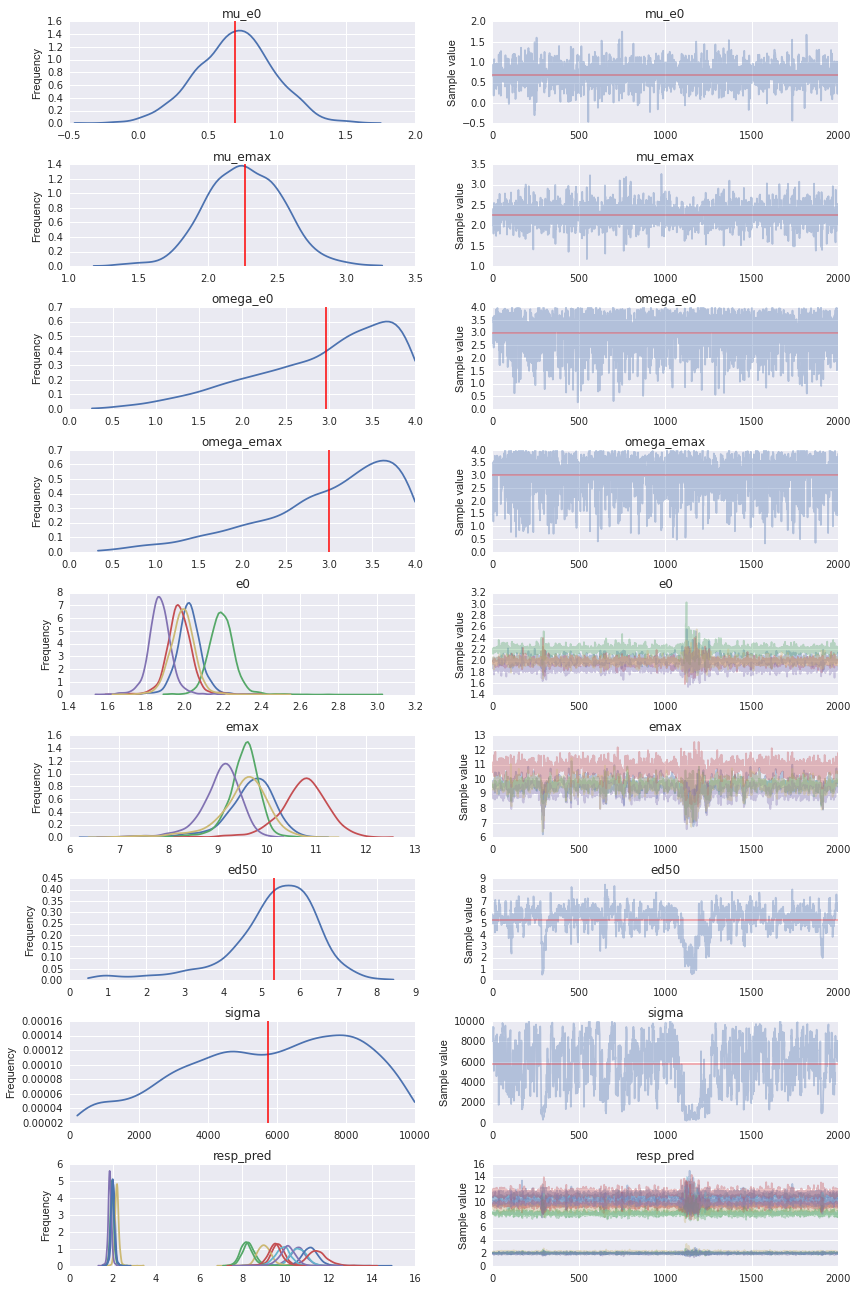

In [191]:
from pymc3 import traceplot

t =traceplot(trace, lines={k: v['mean'] for k, v in df_summary(trace).iterrows()})

### Plot the predicted values from trace on top of the original data 

[-10, 100, 0, 15]

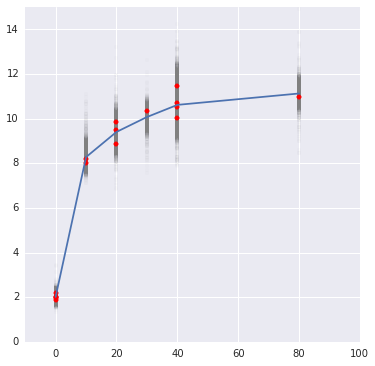

In [194]:
t_df = trace_to_dataframe(trace)
filter_col = [col for col in list(t_df) if col.startswith('resp_pred__')]
col= pd.DataFrame()
to_col =pd.DataFrame()

for n, cols in enumerate(filter_col):
        to_col['resp_pred']=t_df[cols]
        to_col['dose'] = dose[n]
        col = pd.concat([col, to_col])
plt.figure(figsize=(6,6))
plt.scatter(col['dose'], col['resp_pred'], alpha =0.02, s= 15 ,color ='grey')
plt.scatter(data.Dose, data.Mean_response, alpha =1, color='red')
means = col.groupby('dose', as_index=False).aggregate(np.mean)
plt.plot(means.dose, means.resp_pred)
plt.axis([-10, 100, 0, 15])

### Create dataframe to plot each study separately

In [172]:
col= np.empty([1,5])

for n, cols in enumerate(filter_col):
        a = study[n]+1
        b = dose[n]
        c = t_df[cols].quantile(q=0.5)
        d = t_df[cols].quantile(q=0.95)
        e = t_df[cols].quantile(q=0.05)        
        f = np.array([a,b,c,d,e]).reshape(1,5)
        col = np.concatenate((col,f)) 
        
col = np.delete(col, (0), axis=0)
col = pd.DataFrame(col, columns=['study', 'dose', 'mean', 'max', 'min'])
col = col.sort_index(by=['study'])

In [186]:
col.head()

,study,dose,mean,max,min
0,1,0,2.025731,2.163471,1.877894
1,1,10,8.296335,8.960095,7.843571
2,1,20,9.650031,10.216048,9.123637
3,1,40,10.567382,11.184445,9.837647
4,2,0,2.194420,2.346511,2.054110


### And now plot individual studies using seaborn

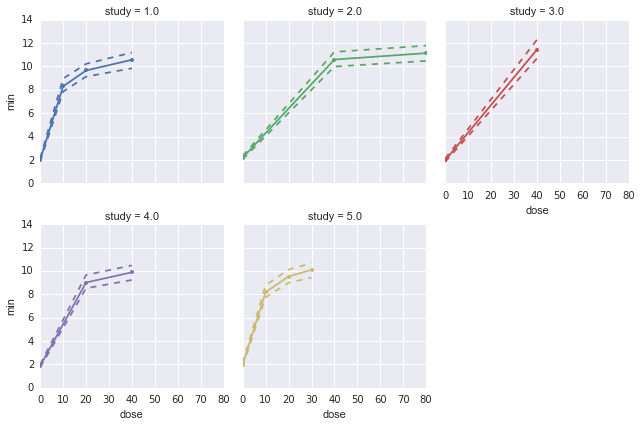

In [185]:
effect= sns.FacetGrid(col, col="study",hue ="study" ,col_wrap=3, size=3, sharex=True)
effect.map(plt.plot, "dose", "mean", marker="o", ms=4)
effect.map(plt.plot, "dose", "max", linestyle ='--')
effect.map(plt.plot, "dose", "min", linestyle ='--')